<a href="https://colab.research.google.com/github/Avanthika8/Major_Project_2025/blob/main/YAMNET_AUDIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn==1.3.0 # Downgrade scikit-learn to a compatible version

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 43.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.3.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.0 which is incompatible.


In [2]:
 !pip install xgboost --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 2.1 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.3
    Uninstalling xgboost-2.1.3:
      Successfully uninstalled xgboost-2.1.3


In [3]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import librosa

from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Load YAMNet model
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet = hub.load(yamnet_model_handle)

In [5]:
# Function to extract embeddings from audio
def extract_yamnet_embeddings(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=16000)  # Load audio
        waveform = tf.convert_to_tensor(audio, dtype=tf.float32)
        scores, embeddings, spectrogram = yamnet(waveform)  # Extract embeddings
        return np.mean(embeddings.numpy(), axis=0)  # Use mean embedding
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [6]:
# Dataset path
dataset_path = "/content/drive/MyDrive/Pneumonia_Project/Datasets/Audio/Audio_Final_Dataset"  # Change this to your dataset location
categories = ["Non-Pneumonia", "Pneumonia"]

In [7]:
data, labels = [], []

In [8]:
# Process audio files
for category in categories:
    folder_path = os.path.join(dataset_path, category)
    for filename in os.listdir(folder_path):
        if filename.endswith(".wav"):
            file_path = os.path.join(folder_path, filename)
            embedding = extract_yamnet_embeddings(file_path)
            if embedding is not None:
                data.append(embedding)
                labels.append(category)

In [9]:
# Convert to NumPy arrays
data = np.array(data)
labels = np.array(labels)

In [10]:
# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

In [12]:
# Train Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [13]:
# Train Support Vector Machine (SVM) Classifier
svm_clf = SVC(kernel='linear', probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

In [14]:
# Train XGBoost Classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:12:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [15]:
# Predictions
y_pred_rf = rf_clf.predict(X_test)
y_pred_svm = svm_clf.predict(X_test)
y_pred_xgb = xgb_clf.predict(X_test)

In [20]:
# Evaluation
print("Random Forest Classifier:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(classification_report(y_test, y_pred_rf, target_names=categories))

Random Forest Classifier:
Accuracy: 0.9537
               precision    recall  f1-score   support

Non-Pneumonia       0.96      1.00      0.98       243
    Pneumonia       0.83      0.31      0.45        16

     accuracy                           0.95       259
    macro avg       0.89      0.65      0.72       259
 weighted avg       0.95      0.95      0.94       259



Confusion Matrix:
[[242   1]
 [ 11   5]]


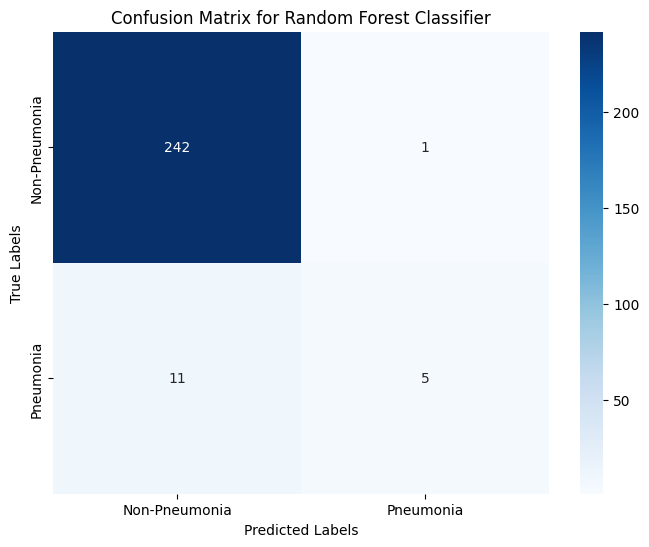

In [21]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix for Random Forest Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [23]:
print("\nSupport Vector Machine Classifier:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(classification_report(y_test, y_pred_svm, target_names=categories))


Support Vector Machine Classifier:
Accuracy: 0.9614
               precision    recall  f1-score   support

Non-Pneumonia       0.96      1.00      0.98       243
    Pneumonia       1.00      0.38      0.55        16

     accuracy                           0.96       259
    macro avg       0.98      0.69      0.76       259
 weighted avg       0.96      0.96      0.95       259



Confusion Matrix:
[[243   0]
 [ 10   6]]


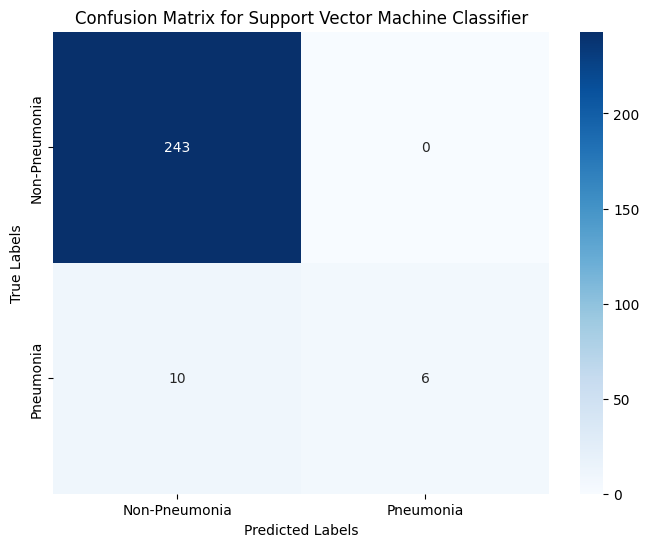

In [24]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix for Support Vector Machine Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [25]:
print("\nXGBoost Classifier:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(classification_report(y_test, y_pred_xgb, target_names=categories))


XGBoost Classifier:
Accuracy: 0.9537
               precision    recall  f1-score   support

Non-Pneumonia       0.96      0.99      0.98       243
    Pneumonia       0.75      0.38      0.50        16

     accuracy                           0.95       259
    macro avg       0.86      0.68      0.74       259
 weighted avg       0.95      0.95      0.95       259



Confusion Matrix:
[[241   2]
 [ 10   6]]


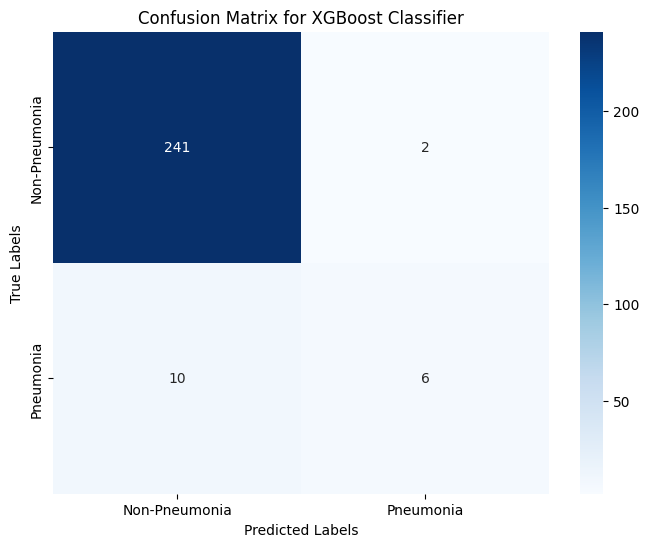

In [26]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix for XGBoost Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()